In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [36]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [37]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))
    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].where((df["현재 대출 잔액"] > 0), np.nan)
    df["현재 대출 잔액"] = df["현재 대출 잔액"].fillna(df["현재 대출 잔액"].median())
    df["최대 신용한도"] = df["최대 신용한도"].where((df["최대 신용한도"] > 0), np.nan)
    df["최대 신용한도"] = df["최대 신용한도"].fillna(df["최대 신용한도"].median())
    df["대출액+신용액"] = df["현재 대출 잔액"] + df["현재 미상환 신용액"]
    df["상환액 분위"] = pd.qcut(df["대출액+신용액"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    df["직장근속연수 분위수"] = pd.qcut(df["현재 직장 근속 연수"], 7, labels = [1,2,3,4,5], duplicates= "drop").astype(int)
    

    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] + df["현재 미상환 신용액"] )  / ((df["최대 신용한도"] * df["개설된 신용계좌 수"]))* 100

    df["DTI"] = ((df["현재 대출 잔액"] + df["현재 미상환 신용액"]) / df["연간 소득"]) * 100
    df["DTR"] = ((df["월 상환 부채액"] + 1) / (df["연간 소득"] / 12)) * 100

    df["DTI분위"] = pd.qcut(df["DTI"], 5, labels = [1,2,3,4,5], duplicates= "drop")
    df["DTR분위"] = pd.qcut(df["DTR"], 5, labels = [1,2,3,4,5], duplicates= "drop")
    df["DBI"] = (df["DTI"] + df["DTR"]) / 2
    df["DRS"] = (df["DTI"] * df["DTR"])

    df["신용위험"] = ((df["개설된_신용계좌_분위수"] >= 3) & (df["신용점수분위"] <= 3) & (df["신용거래분위"] <= 3)).astype(int)
    df["소득위험"] = ((df["직장근속연수 분위수"] < 3) & (df["연간소득분위"] < 3)).astype(int)
    df["대출위험"] = ((df["상환액 분위"] > 3) & (df["DTR분위"] < 3)).astype(int)
    df["파산위험"] = ((df["신용 문제 발생 횟수"] > 0) & ((df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0))).astype(int)

    df["위험분자"] = df["신용위험"] + df["소득위험"] + df["대출위험"] + df["파산위험"]


    df["근속연수vs거래연수"] = (df["현재 직장 근속 연수"] / df["신용 거래 연수"]) * 100


    #df["위험도 점수"] = df["신용점수분위"] - df["상환액 분위"]
    #df["위험도 점수2"] = df["신용거래분위"] - df["개설된_신용계좌_분위수"]
    #df["위험도 점수3"] = df["직장근속연수 분위수"] - df["대출잔액 분위수"]

    #df["문제 발생 점수"] = df["신용 문제 발생 횟수"] + df["개인 파산 횟수"] + df["체납 세금 압류 횟수"]


    #df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용점수분위"] > 3)).astype(int)


    df["개설계좌vs연체이후개월수"] = df["개설된 신용계좌 수"] / (df["마지막 연체 이후 경과 개월 수"] + 1) * 100
    


    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    #df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    신용대출 = df.groupby("개설된 신용계좌 수")["현재 대출 잔액"].agg("mean")
    #df["신용계좌vs대출잔액"] = df["개설된 신용계좌 수"].map(신용대출)
    #df["신용계좌vs대출잔액"] = df["신용계좌vs대출잔액"] / 10000
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
        
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)  

    df = df.drop(["대출액+신용액", "상환액 분위", "DTI분위", "DTR분위"], axis = 1)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,DTR,DBI,DRS,신용위험,소득위험,대출위험,파산위험,위험분자,근속연수vs거래연수,개설계좌vs연체이후개월수
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,5.444185,18.596728,172.848896,0,0,0,0,0,76.923077,36.000000
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,15.132571,34.515788,815.630522,0,0,0,0,0,66.666667,41.666667
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,10.678416,31.711554,563.229756,0,1,0,1,2,22.222222,16.000000
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,36.319699,49.836847,2300.998057,0,0,0,1,1,42.857143,65.217391
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,1.628529,15.190485,46.824188,0,0,1,0,1,7.692308,33.333333


C:\Users\yunju\AppData\Local\Temp\ipykernel_76904\235274021.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})


<Axes: xlabel='신용 점수', ylabel='Density'>

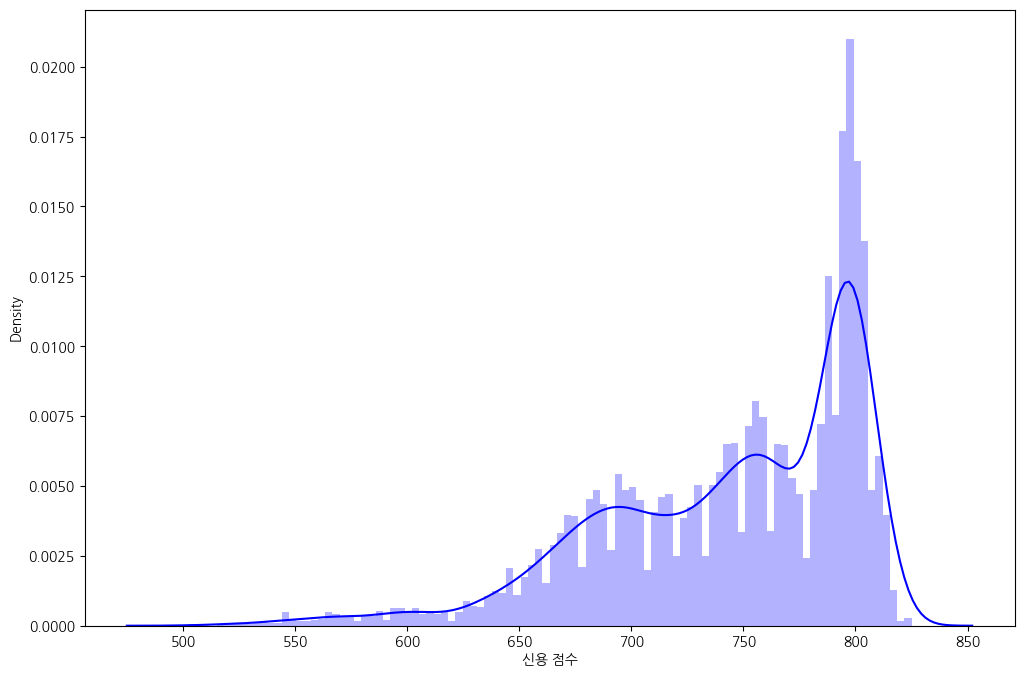

In [38]:
plt.rc("font", family = "NanumGothic")
plt.figure(figsize = (12,8))
sns.distplot(train["신용 점수"], color = "b", bins = 100, hist_kws = {"alpha": 0.3})

In [39]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [40]:
from scipy.stats import boxcox
from scipy.special import boxcox1p

cols = ["최대 신용한도", "연간 소득", "월 상환 부채액", "현재 대출 잔액", "현재 미상환 신용액", "근속연수vs거래연수", "신용한도vs대출잔액", "신용 점수", "DTI", "DTR", "개설계좌vs연체이후개월수", "DBI", "DRS", "개설된 신용계좌 수", "신용 거래 연수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   최대 신용한도        10000 non-null  float64
 1   연간 소득          10000 non-null  float64
 2   월 상환 부채액       10000 non-null  float64
 3   현재 대출 잔액       10000 non-null  float64
 4   현재 미상환 신용액     10000 non-null  float64
 5   근속연수vs거래연수     10000 non-null  float64
 6   신용한도vs대출잔액     10000 non-null  float64
 7   신용 점수          10000 non-null  float64
 8   DTI            10000 non-null  float64
 9   DTR            10000 non-null  float64
 10  개설계좌vs연체이후개월수  10000 non-null  float64
 11  DBI            10000 non-null  float64
 12  DRS            10000 non-null  float64
 13  개설된 신용계좌 수     10000 non-null  float64
 14  신용 거래 연수       10000 non-null  float64
dtypes: float64(15)
memory usage: 1.1 MB
None


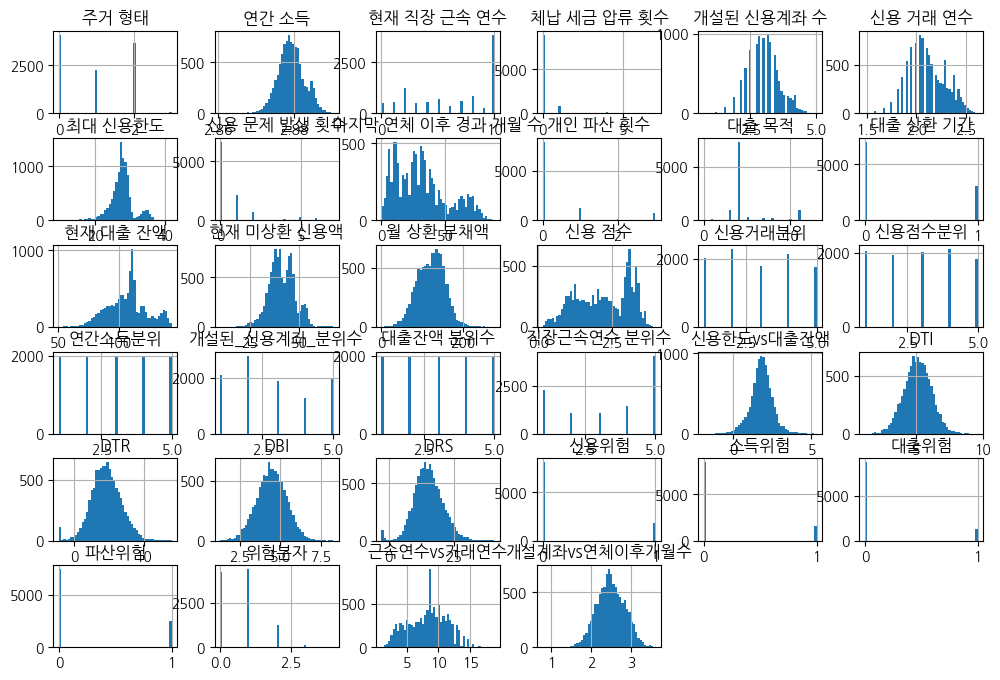

In [41]:
train.hist(figsize = (12,8),bins = 50);

In [42]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)
"""
standard = StandardScaler()
X_scaled = standard.fit_transform(train)
test_scaled = standard.transform(test)
"""

'\nstandard = StandardScaler()\nX_scaled = standard.fit_transform(train)\ntest_scaled = standard.transform(test)\n'

In [43]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5154 - loss: 0.6961 - val_accuracy: 0.5653 - val_loss: 0.6832
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5288 - loss: 0.6925 - val_accuracy: 0.5873 - val_loss: 0.6790
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5466 - loss: 0.6849 - val_accuracy: 0.6119 - val_loss: 0.6752
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5516 - loss: 0.6864 - val_accuracy: 0.6267 - val_loss: 0.6716
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5571 - loss: 0.6796 - val_accuracy: 0.6351 - val_loss: 0.6682
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5624 - loss: 0.6800 - val_accuracy: 0.6449 - val_loss: 0.6645
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5856 - loss: 0.6749 - val_accuracy: 0.6548 - val_loss: 0.6609
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5920 - loss: 0.6725 - val_accuracy: 0.6590

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4778 - loss: 0.7035 - val_accuracy: 0.4801 - val_loss: 0.6972
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4962 - loss: 0.6967 - val_accuracy: 0.5013 - val_loss: 0.6932
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5042 - loss: 0.6938 - val_accuracy: 0.5400 - val_loss: 0.6895
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5235 - loss: 0.6910 - val_accuracy: 0.5708 - val_loss: 0.6861
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5438 - loss: 0.6873 - val_accuracy: 0.5882 - val_loss: 0.6826
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5616 - loss: 0.6838 - val_accuracy: 0.5985 - val_loss: 0.6791
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5758 - loss: 0.6803 - val_accuracy: 0.6110 - val_loss: 0.6755
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5826 - loss: 0.6785 - val_accuracy: 0.6159

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5070 - loss: 0.6964 - val_accuracy: 0.5139 - val_loss: 0.6935
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5089 - loss: 0.6940 - val_accuracy: 0.5510 - val_loss: 0.6906
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5249 - loss: 0.6912 - val_accuracy: 0.5844 - val_loss: 0.6879
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5423 - loss: 0.6873 - val_accuracy: 0.5981 - val_loss: 0.6850
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5440 - loss: 0.6871 - val_accuracy: 0.6125 - val_loss: 0.6821
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5679 - loss: 0.6842 - val_accuracy: 0.6224 - val_loss: 0.6790
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5751 - loss: 0.6826 - val_accuracy: 0.6254 - val_loss: 0.6757
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5859 - loss: 0.6785 - val_accuracy: 0.6277

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4981 - loss: 0.7254 - val_accuracy: 0.5116 - val_loss: 0.6981
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5100 - loss: 0.7050 - val_accuracy: 0.5514 - val_loss: 0.6905
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5071 - loss: 0.6982 - val_accuracy: 0.5624 - val_loss: 0.6868
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5377 - loss: 0.6897 - val_accuracy: 0.5772 - val_loss: 0.6837
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5452 - loss: 0.6887 - val_accuracy: 0.5784 - val_loss: 0.6808
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5687 - loss: 0.6824 - val_accuracy: 0.5966 - val_loss: 0.6772
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5604 - loss: 0.6820 - val_accuracy: 0.6034 - val_loss: 0.6738
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5800 - loss: 0.6770 - val_acc

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5063 - loss: 0.6972 - val_accuracy: 0.5332 - val_loss: 0.6897
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5161 - loss: 0.6940 - val_accuracy: 0.5499 - val_loss: 0.6853
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5216 - loss: 0.6928 - val_accuracy: 0.5693 - val_loss: 0.6812
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5474 - loss: 0.6867 - val_accuracy: 0.5970 - val_loss: 0.6769
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5527 - loss: 0.6843 - val_accuracy: 0.6194 - val_loss: 0.6727
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5707 - loss: 0.6804 - val_accuracy: 0.6345 - val_loss: 0.6685
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5884 - loss: 0.6738 - val_accuracy: 0.6406 - val_loss: 0.6645
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5968 - loss: 0.6714 - val_accu

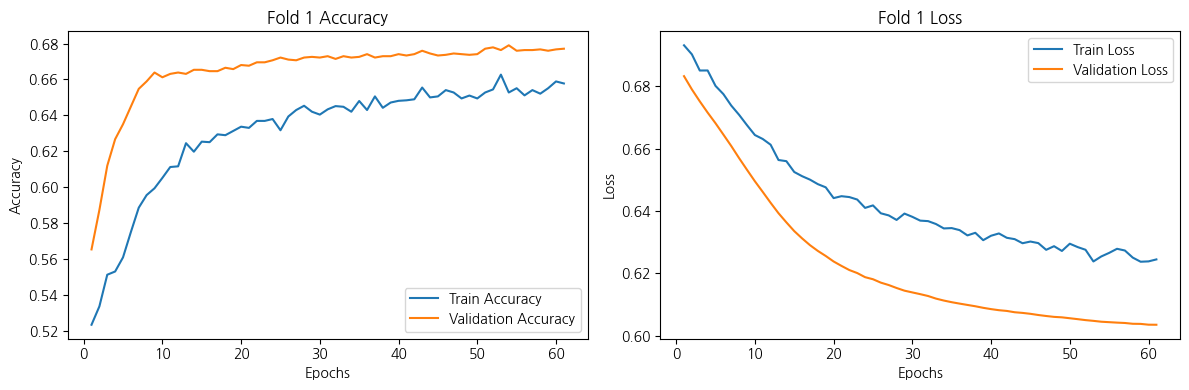

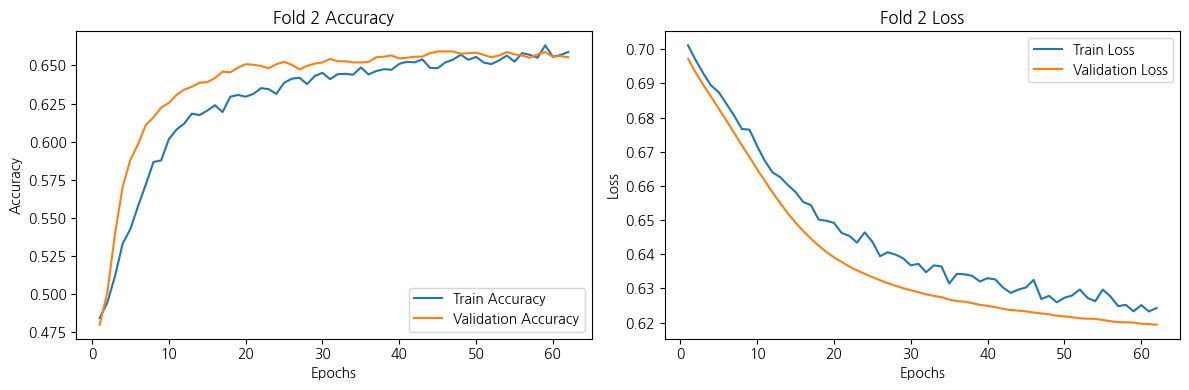

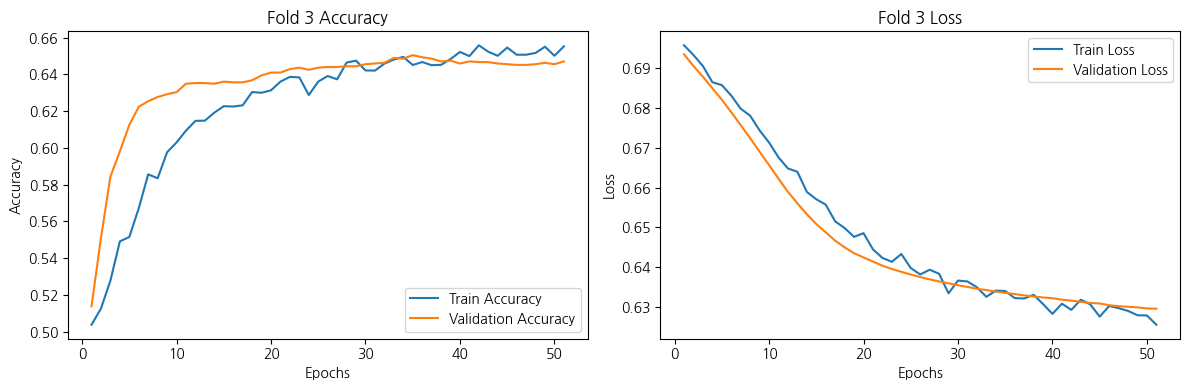

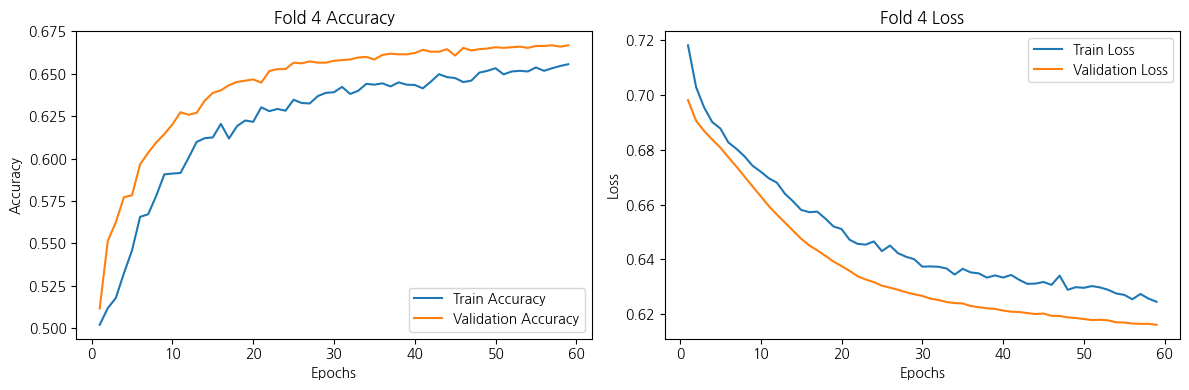

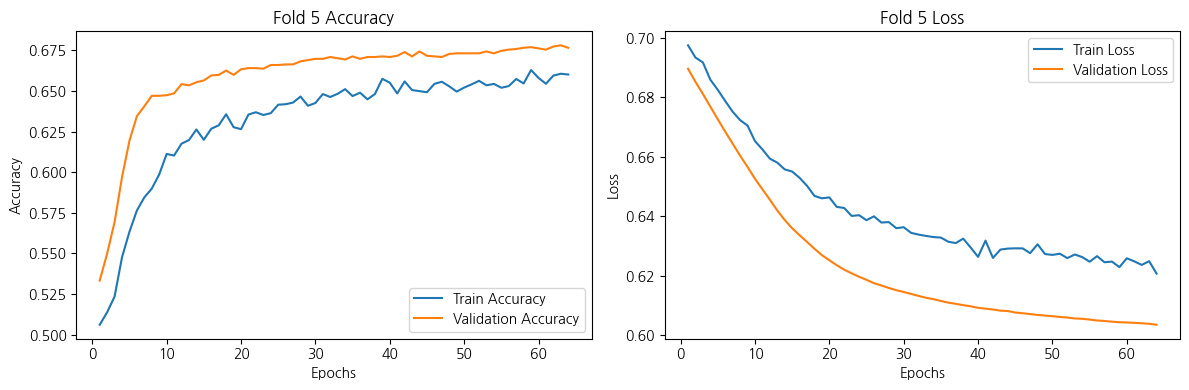

In [44]:
all_history = []
kf = KFold(n_splits= 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]
    print(f"Fold {fold} 시작!")

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation= "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = early_stop,
        verbose = 1,
    )

    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"FOLD {fold} ROC-AUC SCORE {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균 점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.title(f"Fold {i+1} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.title(f"Fold {i+1} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [45]:
pred = model.predict(test_scaled).ravel()


submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100 })
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission(2025-03-17).csv", index = False)
submission.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


,UID,채무 불이행 확률
0,TEST_0000,73.670494
1,TEST_0001,40.523113
2,TEST_0002,35.780014
3,TEST_0003,24.571415
4,TEST_0004,40.981567
